# Mask R-CNN - Train on Custom Dataset


This notebook shows how to train Mask R-CNN on your own dataset using a port of the https://github.com/matterport/Mask_RCNN project to PyTorch (PyTorch project repo: https://github.com/multimodallearning/pytorch-mask-rcnn).

Prerequisite:  run the Setup_and_Demo.ipynb first to build two important extensions required for this project.

Further reading on Mask RCNN and very similar approach (associated with the codebase from which this is the PyTorch port):  https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46


Data links found below in the Fish Dataset section.

To add data use the VGG Image Annotator tool found here for web use or download:  http://www.robots.ox.ac.uk/~vgg/software/via/.

This notebook is roughly based on the https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb from the matterport MaskRCNN with TensorFlow.

**Docker Notes**

* Use `docker commit` to take a container and save as an image to the running docker instance.  Then use `docker save` to save it to an archived file for backup purposes.
* Avoid updating Docker while working on a project such as this or changing the "Disk image max size" in Settings as this could erase the images and containers.


In [1]:
import torch
torch.__version__

'0.3.1'

**Get the Base Model**

Download from [here](https://drive.google.com/file/d/1VV6WgX_RNl6a9Yi9-Pe7ZyVKHRJZSKkm/view).  Note, it is 245MB.

In [2]:
%load_ext autoreload
%autoreload 2


import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import glob
import PIL
from PIL import Image, ImageOps
import skimage
from skimage import draw
import h5py
import torch
from torch.autograd import Variable
import torch.utils.data
from torchvision import datasets
import pycocotools

# from azure.storage import CloudStorageAccount
# from azure.storage.blob import BlockBlobService

# Root directory of the project
TOP_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(TOP_DIR)  # To find local version of the library
from config import Config
import utils
import model as modellib
import visualize
from model import log
import fish_pytorch_style

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory of images to run detection on
DATA_DIR = os.path.join(ROOT_DIR, "fish_pics")


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
# Download this file and place in the root of your
# project (See README file for link to model)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.pth")

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Dataset

This dataset required image files and their annotations (which are the polygon shapes drawn around fish).  Data used for this notebook can be generated by using images of an object of interest, here fish images from a web scrape.  The labels come from polygons created by using the [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/).


Example annotation:
![VGG annotation](images/vgg_annotated_fish.jpg)

### Dealing with getting images - get only as needed

In [5]:
# print(picking_files.loc[picking_files['seenfish_manual'] == True]['frame'])

**Example of using Azure storage SDK to access images in Blob Storage on Azure**

In [6]:
# blockblob_service = BlockBlobService(account_name='your accountname', account_key='your key') # <---- fill in and run

In [7]:
# blob_list = []
# csv_file = ''
# container_name = 'raw'
# folder_name = 'LIS3B2-20170706-3'
# generator = blockblob_service.list_blobs(container_name)

# for blob in generator:
#     # Get frames for a particular folder path
#     if folder_name in blob.name and 'frame' in blob.name:
#         blob_list.append(blob.name)
#     # Get the list of pics with fish in them found in csv file in folder
#     if folder_name in blob.name and 'result_fish' in blob.name:
#         print(blob.name)
#         csv_file = blob.name

In [8]:
# if not os.path.exists(os.path.join('fish_pics', 'next_batch')):
#     os.makedirs(os.path.join('fish_pics', 'next_batch'))

# # Download blobs (frames) (ALL, unless they are specified)
# for blob_name in blob_list:
#     blockblob_service.get_blob_to_path(container_name, blob_name, \
#                                        os.path.join('fish_pics', 'next_batch', \
#                                        blob_name.split('/')[blob_name.count('/')]))

In [9]:
! ls fish_pics/

Annotations_Marieke	 graham_test_train_val.zip  train  via_region_data.json
Annotations_Marieke.zip  test			    val


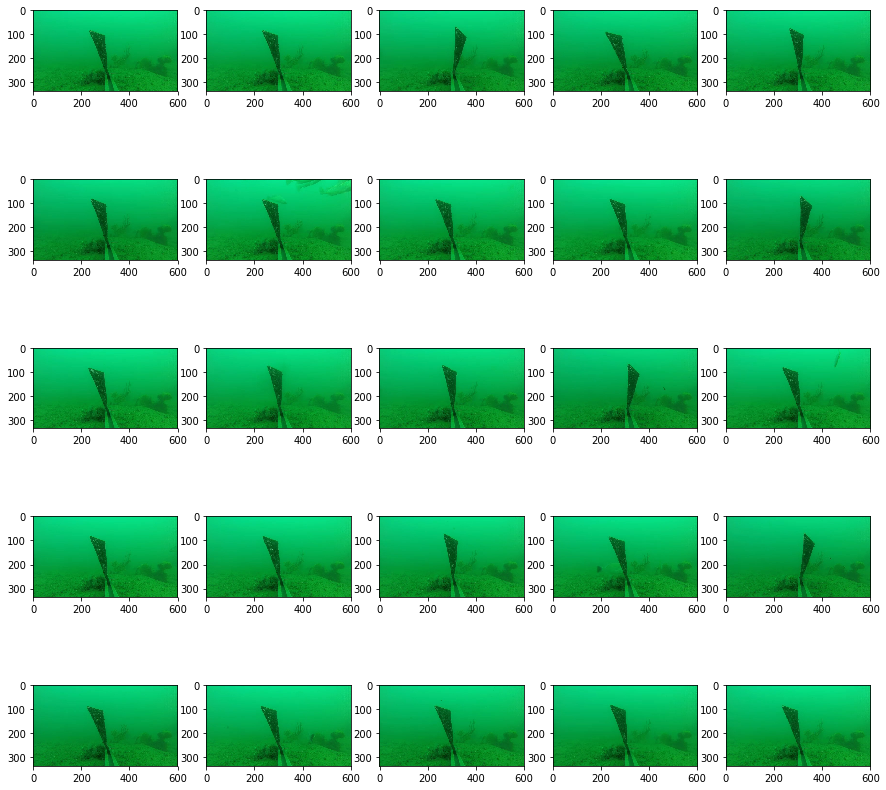

In [10]:
images = glob.glob(os.path.join('fish_pics', 'train', 'video1_frame_*.jpg'))
n_images = len(images)
w=20
h=20
fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 5
for i in range(1, columns*rows + 1):
    if (i-1) == n_images:
        break
    img = plt.imread(images[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Image preprocessing (optional)

In [11]:
import operator
from functools import reduce

def equalize(im):
    h = im.convert("L").histogram()
    lut = []
    for b in range(0, len(h), 256):
        # step size
        step = reduce(operator.add, h[b:b+256]) / 255
        # create equalization lookup table
        n = 0
        for i in range(256):
            lut.append(n / step)
            n = n + h[i+b]
    # map image through lookup table
    return im.point(lut*im.layers)

def resize(im, desired_size):
    old_size = im.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = ImageOps.expand(im, padding)
    new_im = ImageOps.fit(new_im, (int(old_size[0]/2), int(old_size[1]/2)))
    return new_im

import operator

def histogram_strech(im):
    h = im.convert("L").histogram()
    lut = []
    for b in range(0, len(h), 256):
        # step size
        step = reduce(operator.add, h[b:b+256]) / 255
        # create equalization lookup table
        n = 0
        for i in range(256):
            lut.append(n / step)
            n = n + h[i+b]
    # map image through lookup table
    return im.point(lut*im.layers)

from numpy import *

def denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):
    """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
    using the numerical procedure presented in eq (11) A. Chambolle (2005).

    Input: noisy input image (grayscale), initial guess for U, weight of
    the TV-regularizing term, steplength, tolerance for stop criterion.

    Output: denoised and detextured image, texture residual. """

    m,n = im.shape # size of noisy image

    # initialize
    U = U_init
    Px = im # x-component to the dual field
    Py = im # y-component of the dual field
    error = 1

    while (error > tolerance):
        Uold = U

        # gradient of primal variable
        GradUx = roll(U,-1,axis=1)-U # x-component of U's gradient
        GradUy = roll(U,-1,axis=0)-U # y-component of U's gradient

        # update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx
        PyNew = Py + (tau/tv_weight)*GradUy
        NormNew = maximum(1,sqrt(PxNew**2+PyNew**2))

        Px = PxNew/NormNew # update of x-component (dual)
        Py = PyNew/NormNew # update of y-component (dual)

        # update the primal variable
        RxPx = roll(Px,1,axis=1) # right x-translation of x-component
        RyPy = roll(Py,1,axis=0) # right y-translation of y-component

        DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field.
        U = im + tv_weight*DivP # update of the primal variable

        # update of error
        error = linalg.norm(U-Uold)/sqrt(n*m);

    return U,im-U # denoised image and texture residual

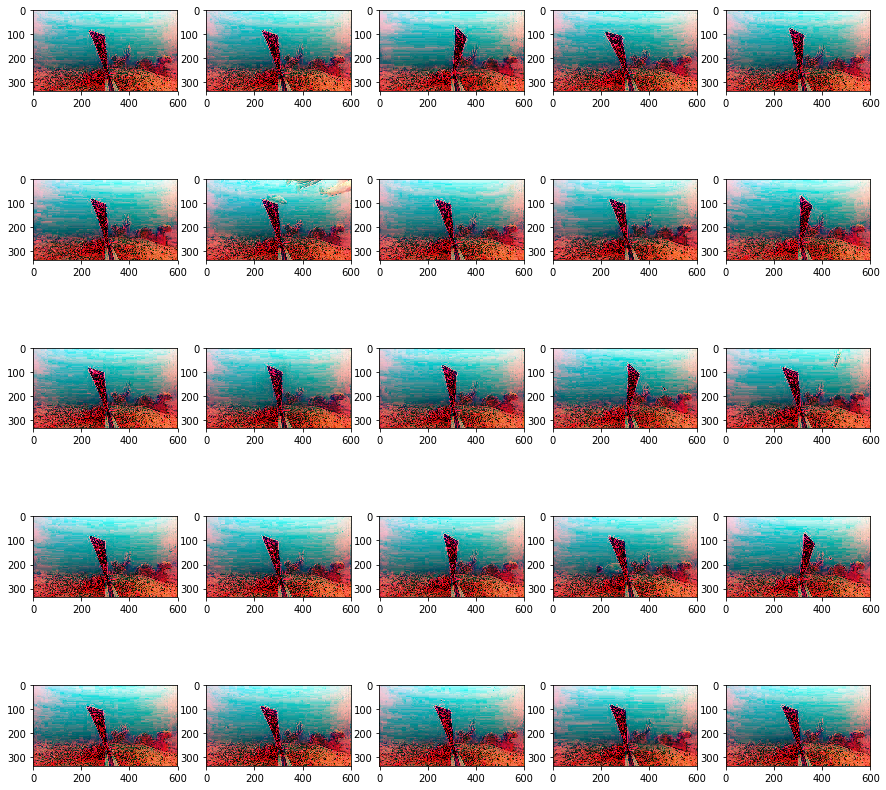

In [12]:
images = glob.glob(os.path.join('fish_pics', 'train', 'video1_frame_*.jpg'))
n_images = len(images)
w=20
h=20
fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 5
for i in range(1, columns*rows + 1):
    if (i-1) == n_images:
        break
    img = Image.open(images[i-1])
    img = ImageOps.equalize(img)
    img = np.asarray(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

###  Dataset Class

This is a custom class extending the `Dataset` class in `utils.py`.  This specifically deals with the annotations exported as json polygons from the VGG Image Annotator.  Note, a mask is the space within the polygon representing the shape and area of the object.

In [13]:
############################################################
#  Dataset
############################################################

class FishDataset(utils.Dataset):

    def load_fish(self, dataset_dir, subset, region_data_json):
        """Load a subset of the fish dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("fish", 1, "fish")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, region_data_json)))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "fish",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a fish dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "fish":
            print ("Not a fish label")
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fish":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

### Initialize Training and Validation Datasets

For the images there are two sub folders inside the images (`fish_pics`) directory, namely: `train` and `val`.  These two subfolders have the images which correspond to labels (polygons here) contained in json file - the output of the VGG Annotator Tool (http://www.robots.ox.ac.uk/~vgg/software/via/via.html).

In [14]:


# Training dataset. Use the training set and 35K from the
# validation set, as as in the Mask RCNN paper.
dataset_train = FishDataset()
dataset_train.load_fish(DATA_DIR, "train", "via_region_data_train.json")
dataset_train.prepare()

dataset_val = FishDataset()
dataset_val.load_fish(DATA_DIR, "val",  "via_region_data_val.json")
dataset_val.prepare()

# Original COCO class names:
# class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush', 'fish']

class_names = ['BG', 'fish']

### Configuration

In [15]:
class FishConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    # Give the configuration a recognizable name
    NAME = "fish"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 2

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.90
    
    
    COCO_MODEL_PATH = os.getcwd() + os.sep + 'mask_rcnn_coco.pth'
    
    VALIDATION_STEPS = 1
    
    BATCH_SIZE = 2
    
    LEARNING_RATE = 0.001
    
    # Necessary for docker immage to optimize memory usage best
    NUM_WORKERS = 0
    
# Configurations
config = FishConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_MODEL_PATH                /home/tpol/pytorch-mask-rcnn-samples/mask_rcnn_coco.pth
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGENET_MODEL_PATH            /home/tpol/pytorch-mask-rcnn-samples/resnet50_imagenet.pth
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE              

## Create Fish Model

Note the "Further reading" link at the top to find out the details of this model.  For a quick summary the model architecture consists of the following modules:

1.  Backbone
  * Resnet CNN as a featurizer
  * Feature Pyramid Network - refines the features to better represent objects at multiple scales.
2.  Region Proposal Network - scans and finds areas that contain objects
  * Output:
    * Anchor class
    * Bounding box refinement
3.  Region of Interest Classifier (using ROI Align for ROI pooling) and Bounding Box Regressor
  * Output
    * Class (Background, BG, included)
    * Bounding box refinement (further refinement)
4.  Segmentation Mask Network (CNN)
  * Output:  "soft" masks (floating point numbers instead of binary mask for comparison)

In [16]:
! ls 

Demo.ipynb			coco		       logs
InstallPyTorchSourceCPU.ipynb	coco.py		       mask_rcnn_coco.pth
InstallPyTorchSourceCUDA.ipynb	config.py	       model.py
LICENSE				demo.py		       model.py.bkup1
README.md			fish_pics	       pycocotools
Setup.ipynb			fish_pytorch_style.py  requirements.txt
Train.ipynb			images		       utils.py
__pycache__			lib		       visualize.py


In [17]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          99G   63G   32G  67% /
tmpfs            64M     0   64M   0% /dev
tmpfs            28G     0   28G   0% /sys/fs/cgroup
/dev/sdc1        99G   63G   32G  67% /etc/hosts
shm              64M     0   64M   0% /dev/shm
tmpfs           5.6G  527M  5.0G  10% /run/docker.sock
tmpfs            28G   12K   28G   1% /proc/driver/nvidia
/dev/sda1        49G   27G   22G  56% /usr/bin/nvidia-smi
udev             28G     0   28G   0% /dev/nvidia0
tmpfs            28G     0   28G   0% /proc/acpi
tmpfs            28G     0   28G   0% /proc/scsi
tmpfs            28G     0   28G   0% /sys/firmware


### Initialize
Using the COCO pretrained weights file (or pretrained model on this data to refine).

In [18]:
%load_ext autoreload
%autoreload 2

# Create model object.
model = modellib.MaskRCNN(model_dir=MODEL_DIR, config=config)
if config.GPU_COUNT > 0:
    print('Cuda!', config.GPU_COUNT)
    model = model.cuda()

# Load weights trained on MS-COCO - all weights
# model.load_state_dict(torch.load(COCO_MODEL_PATH))

# Remove the penultimate layer of MS-COCO
pretrained_state = torch.load(COCO_MODEL_PATH)
model_state = model.state_dict()

pretrained_state = { k:v for k,v in pretrained_state.items() if k in model_state and v.size() == model_state[k].size() }
model_state.update(pretrained_state)
model.load_state_dict(model_state)

# # Use a pretrained model from this notebook
# model.load_state_dict(torch.load(os.path.join('logs', 'fish20180429T0019', 'mask_rcnn_fish_0052.pth')))

# # Remove the penultimate layer of xyz model
# pretrained_state = torch.load(os.path.join('logs', 'fish20180429T0019', 'mask_rcnn_fish_0052.pth'))
# model_state = model.state_dict()

# pretrained_state = { k:v for k,v in pretrained_state.items() if k in model_state and v.size() == model_state[k].size() }
# model_state.update(pretrained_state)
# model.load_state_dict(model_state)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cuda! 1


### Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers='all'` to train all layers.

In [19]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [20]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Training network heads

Starting at epoch 1. LR=0.001

Checkpoint Path: /home/tpol/pytorch-mask-rcnn-samples/logs/fish20181104T2230/mask_rcnn_fish_{:04d}.pth
Epoch 1/5.
	1/4 |██--------| 25.0% Complete - loss: 0.52666 - rpn_class_loss: 0.08655 - rpn_bbox_loss: 0.44011 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	2/4 |█████-----| 50.0% Complete - loss: 2.08795 - rpn_class_loss: 0.01343 - rpn_bbox_loss: 0.10489 - mrcnn_class_loss: 0.64696 - mrcnn_bbox_loss: 0.57284 - mrcnn_mask_loss: 0.74984
	3/4 |███████---| 75.0% Complete - loss: 4.98496 - rpn_class_loss: 0.13253 - rpn_bbox_loss: 2.77903 - mrcnn_class_loss: 0.58578 - mrcnn_bbox_loss: 0.57119 - mrcnn_mask_loss: 0.91644
	4/4 |██████████| 100.0% Complete - loss: 2.32083 - rpn_class_loss: 0.00007 - rpn_bbox_loss: 0.64378 - mrcnn_class_loss: 0.57001 - mrcnn_bbox_loss: 0.60988 - mrcnn_mask_loss: 0.49709

	1/1 |██████████| 100.0% Complete - loss: 3.46520 - rpn_class_loss: 0.58575 - rpn_bbox_loss: 0.77356 

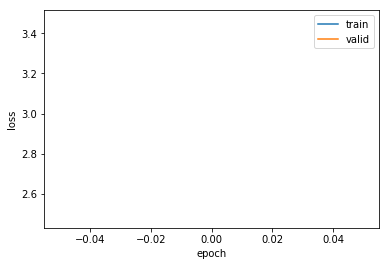

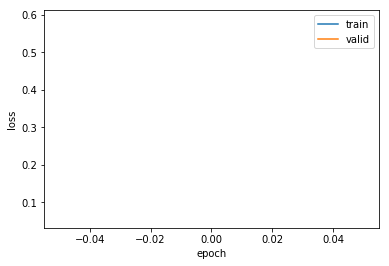

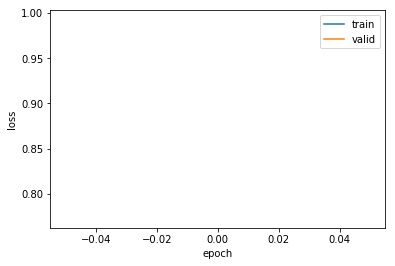

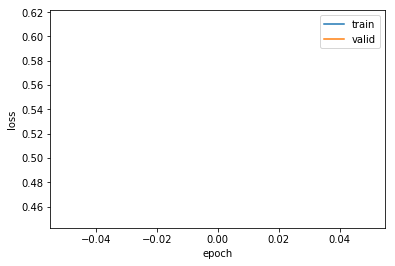

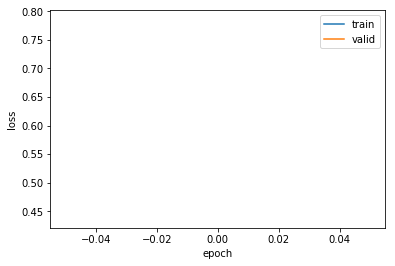

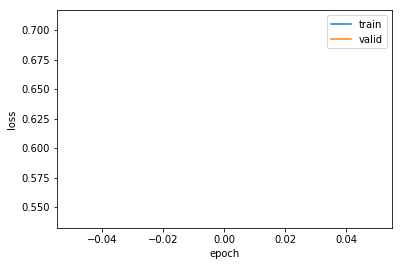

Epoch 2/5.
	1/4 |██--------| 25.0% Complete - loss: 1.96665 - rpn_class_loss: 0.00073 - rpn_bbox_loss: 0.51775 - mrcnn_class_loss: 0.46671 - mrcnn_bbox_loss: 0.54273 - mrcnn_mask_loss: 0.43874
	2/4 |█████-----| 50.0% Complete - loss: 4.85358 - rpn_class_loss: 0.13195 - rpn_bbox_loss: 2.74689 - mrcnn_class_loss: 0.55217 - mrcnn_bbox_loss: 0.56122 - mrcnn_mask_loss: 0.86136
	3/4 |███████---| 75.0% Complete - loss: 2.04005 - rpn_class_loss: 0.02519 - rpn_bbox_loss: 0.37109 - mrcnn_class_loss: 0.48737 - mrcnn_bbox_loss: 0.55090 - mrcnn_mask_loss: 0.60549
	4/4 |██████████| 100.0% Complete - loss: 2.82602 - rpn_class_loss: 0.16559 - rpn_bbox_loss: 0.76508 - mrcnn_class_loss: 0.62669 - mrcnn_bbox_loss: 0.59641 - mrcnn_mask_loss: 0.67225

	1/1 |██████████| 100.0% Complete - loss: 3.37498 - rpn_class_loss: 0.57719 - rpn_bbox_loss: 0.74137 - mrcnn_class_loss: 0.65166 - mrcnn_bbox_loss: 0.76032 - mrcnn_mask_loss: 0.64444



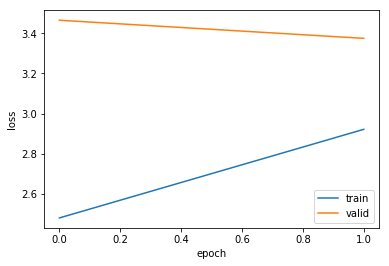

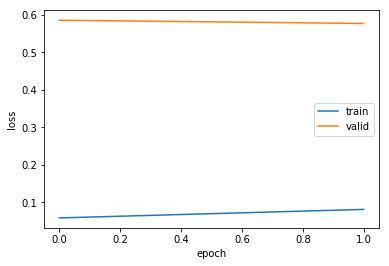

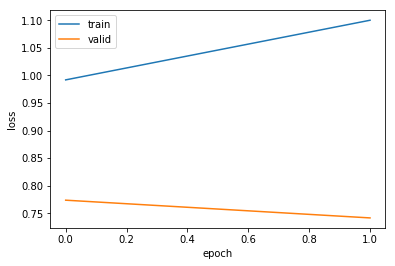

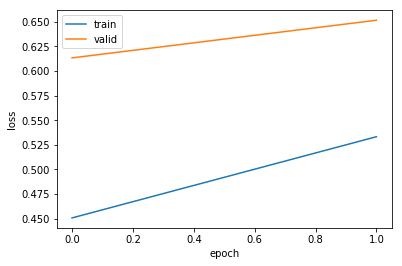

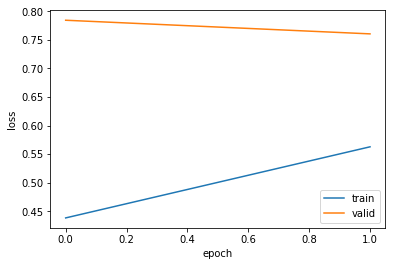

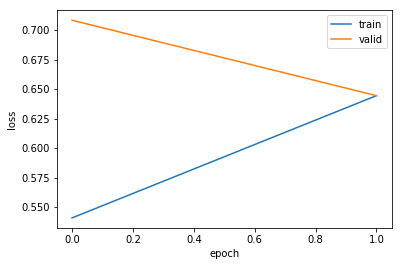

Epoch 3/5.
	1/4 |██--------| 25.0% Complete - loss: 1.56274 - rpn_class_loss: 0.00835 - rpn_bbox_loss: 0.17205 - mrcnn_class_loss: 0.51123 - mrcnn_bbox_loss: 0.43806 - mrcnn_mask_loss: 0.43307
	2/4 |█████-----| 50.0% Complete - loss: 3.93903 - rpn_class_loss: 0.12323 - rpn_bbox_loss: 2.05116 - mrcnn_class_loss: 0.47959 - mrcnn_bbox_loss: 0.59464 - mrcnn_mask_loss: 0.69040
	3/4 |███████---| 75.0% Complete - loss: 1.98556 - rpn_class_loss: 0.02986 - rpn_bbox_loss: 0.26491 - mrcnn_class_loss: 0.65706 - mrcnn_bbox_loss: 0.56302 - mrcnn_mask_loss: 0.47072
	4/4 |██████████| 100.0% Complete - loss: 2.52958 - rpn_class_loss: 0.00962 - rpn_bbox_loss: 0.62305 - mrcnn_class_loss: 0.66243 - mrcnn_bbox_loss: 0.68408 - mrcnn_mask_loss: 0.55041

	1/1 |██████████| 100.0% Complete - loss: 3.05419 - rpn_class_loss: 0.11179 - rpn_bbox_loss: 0.82547 - mrcnn_class_loss: 0.39274 - mrcnn_bbox_loss: 0.98304 - mrcnn_mask_loss: 0.74114



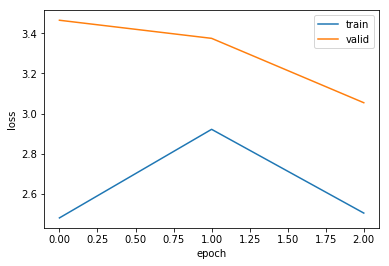

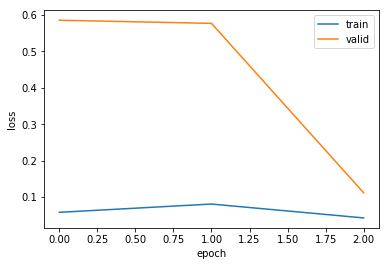

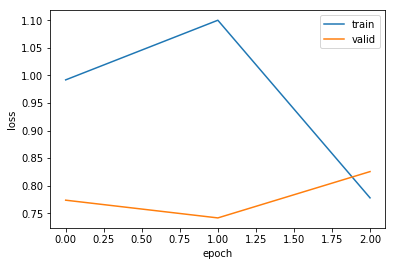

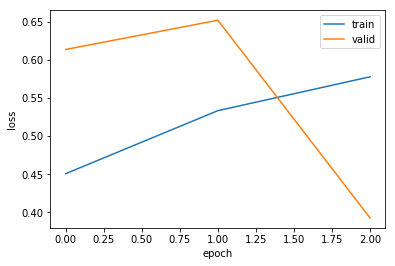

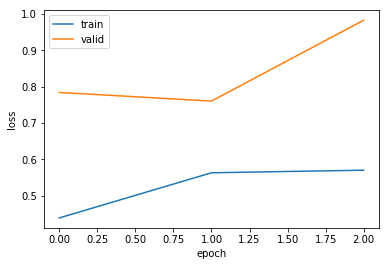

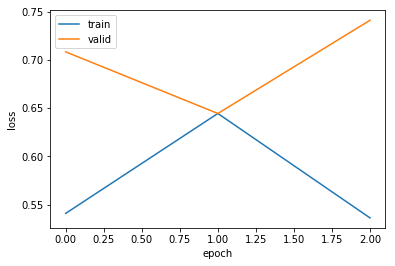

Epoch 4/5.
	1/4 |██--------| 25.0% Complete - loss: 1.61242 - rpn_class_loss: 0.00801 - rpn_bbox_loss: 0.18022 - mrcnn_class_loss: 0.49528 - mrcnn_bbox_loss: 0.55149 - mrcnn_mask_loss: 0.37742
	2/4 |█████-----| 50.0% Complete - loss: 1.69609 - rpn_class_loss: 0.00051 - rpn_bbox_loss: 0.16041 - mrcnn_class_loss: 0.50647 - mrcnn_bbox_loss: 0.63571 - mrcnn_mask_loss: 0.39298
	3/4 |███████---| 75.0% Complete - loss: 2.36561 - rpn_class_loss: 0.09329 - rpn_bbox_loss: 0.78585 - mrcnn_class_loss: 0.46098 - mrcnn_bbox_loss: 0.56170 - mrcnn_mask_loss: 0.46379
	4/4 |██████████| 100.0% Complete - loss: 2.31761 - rpn_class_loss: 0.13769 - rpn_bbox_loss: 0.37938 - mrcnn_class_loss: 0.61776 - mrcnn_bbox_loss: 0.59384 - mrcnn_mask_loss: 0.58894

	1/1 |██████████| 100.0% Complete - loss: 3.43139 - rpn_class_loss: 0.58005 - rpn_bbox_loss: 0.76928 - mrcnn_class_loss: 0.75757 - mrcnn_bbox_loss: 0.65871 - mrcnn_mask_loss: 0.66577



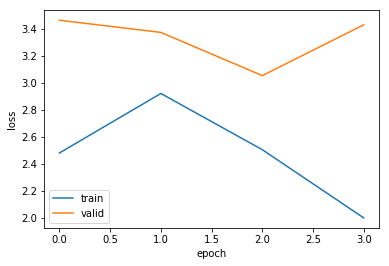

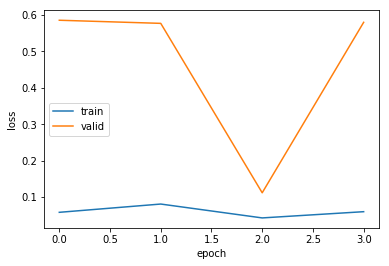

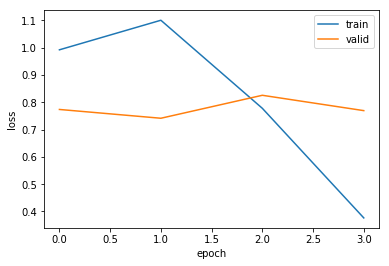

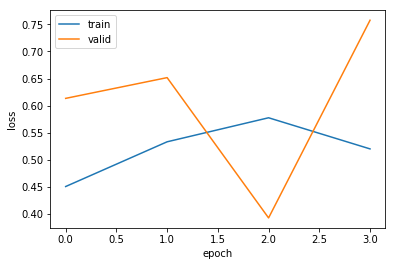

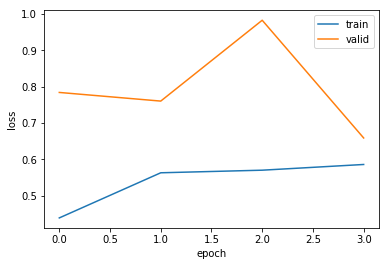

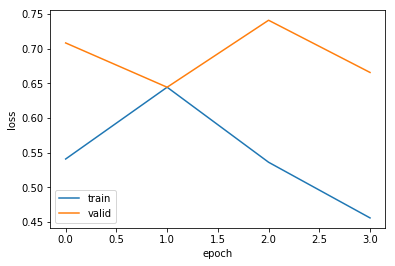

Epoch 5/5.
	1/4 |██--------| 25.0% Complete - loss: 2.37326 - rpn_class_loss: 0.05728 - rpn_bbox_loss: 0.43889 - mrcnn_class_loss: 0.69384 - mrcnn_bbox_loss: 0.66471 - mrcnn_mask_loss: 0.51854
	2/4 |█████-----| 50.0% Complete - loss: 1.54177 - rpn_class_loss: 0.00080 - rpn_bbox_loss: 0.35416 - mrcnn_class_loss: 0.33388 - mrcnn_bbox_loss: 0.52588 - mrcnn_mask_loss: 0.32705
	3/4 |███████---| 75.0% Complete - loss: 1.59388 - rpn_class_loss: 0.00640 - rpn_bbox_loss: 0.17354 - mrcnn_class_loss: 0.44545 - mrcnn_bbox_loss: 0.58858 - mrcnn_mask_loss: 0.37991
	4/4 |██████████| 100.0% Complete - loss: 2.06655 - rpn_class_loss: 0.12225 - rpn_bbox_loss: 0.22927 - mrcnn_class_loss: 0.53209 - mrcnn_bbox_loss: 0.60509 - mrcnn_mask_loss: 0.57785

	1/1 |██████████| 100.0% Complete - loss: 3.25288 - rpn_class_loss: 0.52187 - rpn_bbox_loss: 0.72094 - mrcnn_class_loss: 0.67019 - mrcnn_bbox_loss: 0.74456 - mrcnn_mask_loss: 0.59532



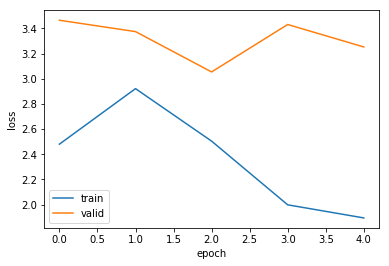

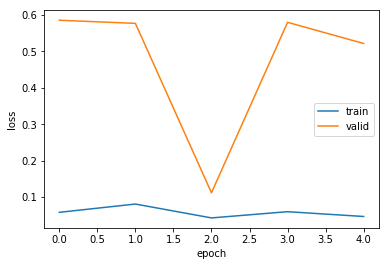

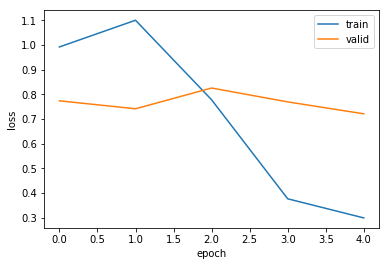

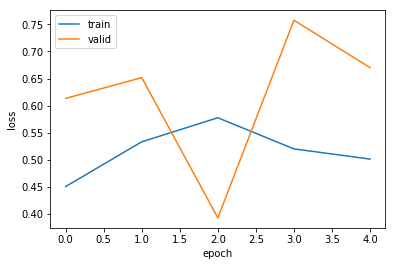

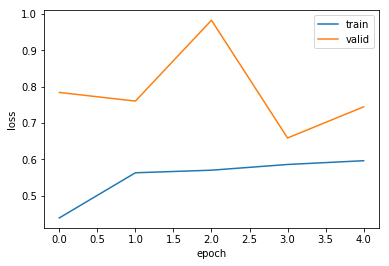

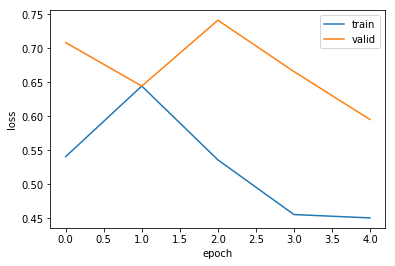

Fine tune Resnet stage 4 and up

Starting at epoch 6. LR=0.001

Checkpoint Path: /home/tpol/pytorch-mask-rcnn-samples/logs/fish20181104T2230/mask_rcnn_fish_{:04d}.pth
Epoch 6/10.
	1/4 |██--------| 25.0% Complete - loss: 2.56690 - rpn_class_loss: 0.01682 - rpn_bbox_loss: 0.57011 - mrcnn_class_loss: 0.64244 - mrcnn_bbox_loss: 0.76489 - mrcnn_mask_loss: 0.57264
	2/4 |█████-----| 50.0% Complete - loss: 1.57343 - rpn_class_loss: 0.00129 - rpn_bbox_loss: 0.09772 - mrcnn_class_loss: 0.41215 - mrcnn_bbox_loss: 0.70039 - mrcnn_mask_loss: 0.36188
	3/4 |███████---| 75.0% Complete - loss: 1.25467 - rpn_class_loss: 0.00802 - rpn_bbox_loss: 0.04652 - mrcnn_class_loss: 0.41028 - mrcnn_bbox_loss: 0.46701 - mrcnn_mask_loss: 0.32285
	4/4 |██████████| 100.0% Complete - loss: 1.91581 - rpn_class_loss: 0.11301 - rpn_bbox_loss: 0.18593 - mrcnn_class_loss: 0.47486 - mrcnn_bbox_loss: 0.58357 - mrcnn_mask_loss: 0.55843

	1/1 |██████████| 100.0% Complete - loss: 3.28312 - rpn_class_loss: 0.51949 - rpn_bbox_loss

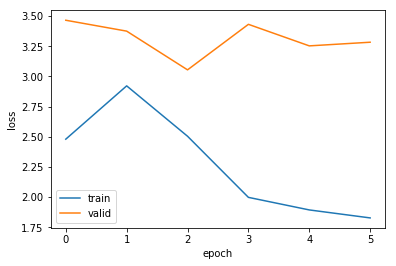

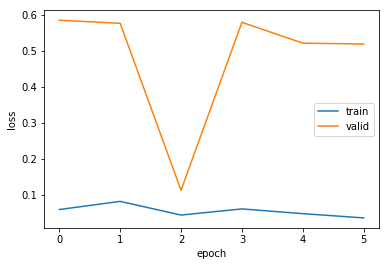

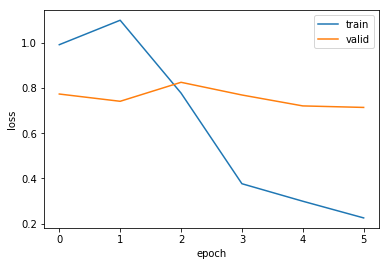

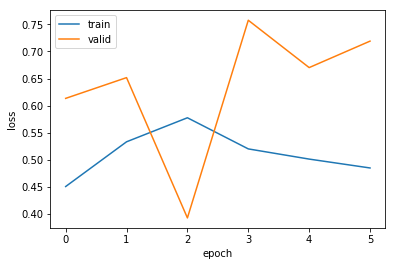

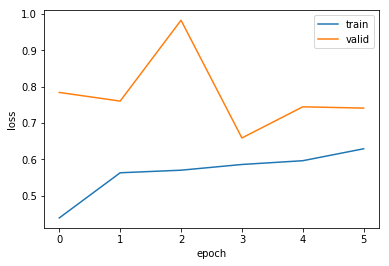

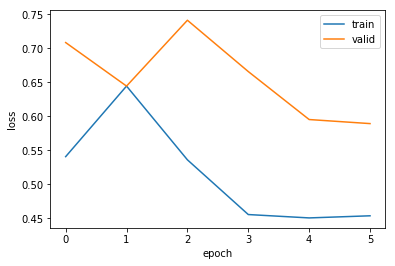

Epoch 7/10.
	1/4 |██--------| 25.0% Complete - loss: 5.97043 - rpn_class_loss: 0.10529 - rpn_bbox_loss: 4.09174 - mrcnn_class_loss: 0.56631 - mrcnn_bbox_loss: 0.62031 - mrcnn_mask_loss: 0.58678
	2/4 |█████-----| 50.0% Complete - loss: 0.58428 - rpn_class_loss: 0.08191 - rpn_bbox_loss: 0.50236 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	3/4 |███████---| 75.0% Complete - loss: 2.06138 - rpn_class_loss: 0.06144 - rpn_bbox_loss: 0.40660 - mrcnn_class_loss: 0.58838 - mrcnn_bbox_loss: 0.50428 - mrcnn_mask_loss: 0.50068
	4/4 |██████████| 100.0% Complete - loss: 2.20169 - rpn_class_loss: 0.00970 - rpn_bbox_loss: 0.47870 - mrcnn_class_loss: 0.60329 - mrcnn_bbox_loss: 0.58342 - mrcnn_mask_loss: 0.52658

	1/1 |██████████| 100.0% Complete - loss: 3.11714 - rpn_class_loss: 0.51358 - rpn_bbox_loss: 0.63089 - mrcnn_class_loss: 0.67147 - mrcnn_bbox_loss: 0.72636 - mrcnn_mask_loss: 0.57484



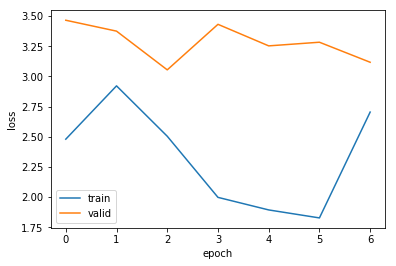

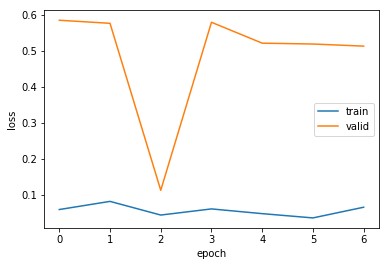

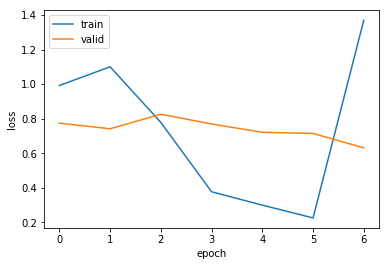

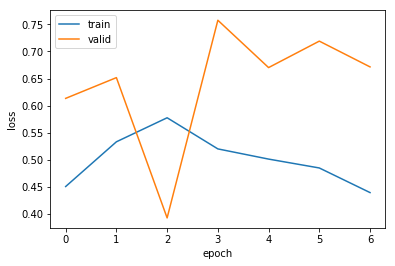

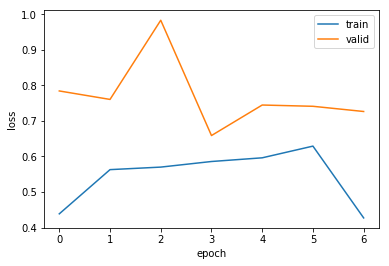

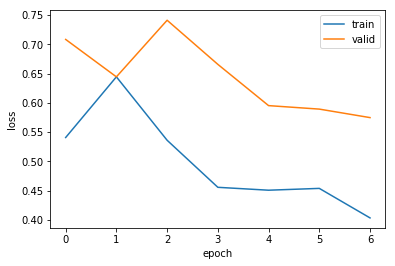

Epoch 8/10.
	1/4 |██--------| 25.0% Complete - loss: 1.31202 - rpn_class_loss: 0.00073 - rpn_bbox_loss: 0.21668 - mrcnn_class_loss: 0.33553 - mrcnn_bbox_loss: 0.46935 - mrcnn_mask_loss: 0.28973
	2/4 |█████-----| 50.0% Complete - loss: 1.13441 - rpn_class_loss: 0.00762 - rpn_bbox_loss: 0.01328 - mrcnn_class_loss: 0.38186 - mrcnn_bbox_loss: 0.42320 - mrcnn_mask_loss: 0.30845
	3/4 |███████---| 75.0% Complete - loss: 1.80187 - rpn_class_loss: 0.10228 - rpn_bbox_loss: 0.17487 - mrcnn_class_loss: 0.45270 - mrcnn_bbox_loss: 0.54920 - mrcnn_mask_loss: 0.52282
	4/4 |██████████| 100.0% Complete - loss: 0.16994 - rpn_class_loss: 0.07413 - rpn_bbox_loss: 0.09581 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000

	1/1 |██████████| 100.0% Complete - loss: 2.92730 - rpn_class_loss: 0.50815 - rpn_bbox_loss: 0.57887 - mrcnn_class_loss: 0.72820 - mrcnn_bbox_loss: 0.54902 - mrcnn_mask_loss: 0.56306



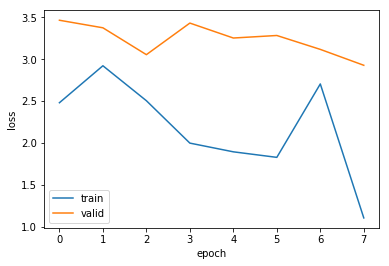

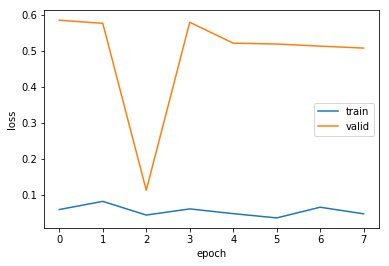

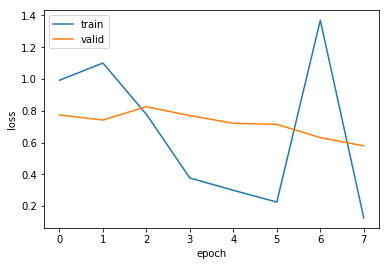

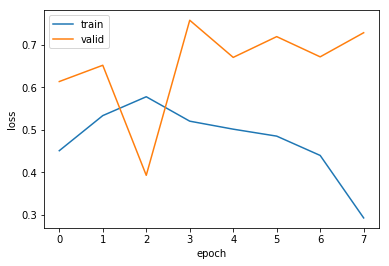

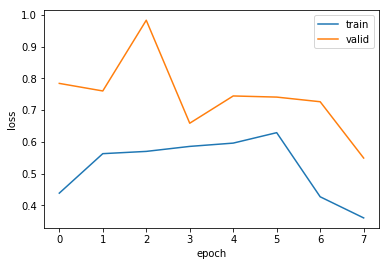

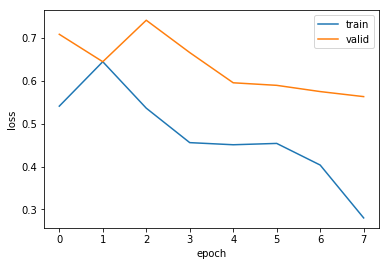

Epoch 9/10.
	1/4 |██--------| 25.0% Complete - loss: 1.15667 - rpn_class_loss: 0.00086 - rpn_bbox_loss: 0.18181 - mrcnn_class_loss: 0.28138 - mrcnn_bbox_loss: 0.41429 - mrcnn_mask_loss: 0.27833
	2/4 |█████-----| 50.0% Complete - loss: 1.76255 - rpn_class_loss: 0.05872 - rpn_bbox_loss: 0.20833 - mrcnn_class_loss: 0.52389 - mrcnn_bbox_loss: 0.50517 - mrcnn_mask_loss: 0.46644
	3/4 |███████---| 75.0% Complete - loss: 1.94573 - rpn_class_loss: 0.00637 - rpn_bbox_loss: 0.37167 - mrcnn_class_loss: 0.53202 - mrcnn_bbox_loss: 0.54789 - mrcnn_mask_loss: 0.48778
	4/4 |██████████| 100.0% Complete - loss: 1.33289 - rpn_class_loss: 0.02246 - rpn_bbox_loss: 0.02795 - mrcnn_class_loss: 0.57036 - mrcnn_bbox_loss: 0.31738 - mrcnn_mask_loss: 0.39474

	1/1 |██████████| 100.0% Complete - loss: 2.01049 - rpn_class_loss: 0.08812 - rpn_bbox_loss: 0.23429 - mrcnn_class_loss: 0.55335 - mrcnn_bbox_loss: 0.62412 - mrcnn_mask_loss: 0.51060



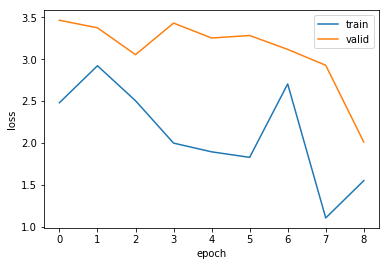

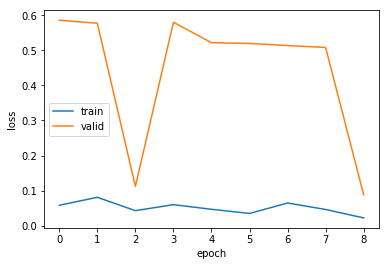

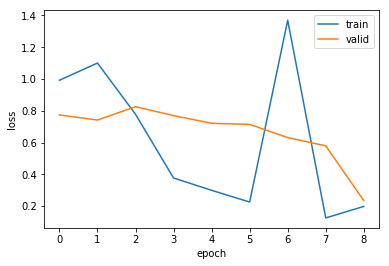

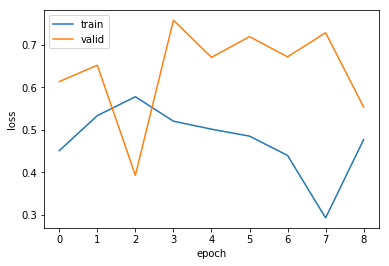

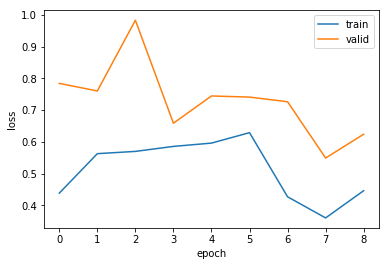

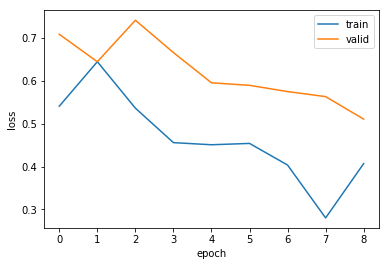

Epoch 10/10.
	1/4 |██--------| 25.0% Complete - loss: 1.30982 - rpn_class_loss: 0.05621 - rpn_bbox_loss: 0.09398 - mrcnn_class_loss: 0.42093 - mrcnn_bbox_loss: 0.32348 - mrcnn_mask_loss: 0.41523
	2/4 |█████-----| 50.0% Complete - loss: 0.31218 - rpn_class_loss: 0.07166 - rpn_bbox_loss: 0.24052 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	3/4 |███████---| 75.0% Complete - loss: 1.46800 - rpn_class_loss: 0.00388 - rpn_bbox_loss: 0.33869 - mrcnn_class_loss: 0.24374 - mrcnn_bbox_loss: 0.53869 - mrcnn_mask_loss: 0.34300
	4/4 |██████████| 100.0% Complete - loss: 1.76422 - rpn_class_loss: 0.00591 - rpn_bbox_loss: 0.32606 - mrcnn_class_loss: 0.47728 - mrcnn_bbox_loss: 0.47212 - mrcnn_mask_loss: 0.48286

	1/1 |██████████| 100.0% Complete - loss: 2.12746 - rpn_class_loss: 0.08486 - rpn_bbox_loss: 0.27856 - mrcnn_class_loss: 0.58504 - mrcnn_bbox_loss: 0.65095 - mrcnn_mask_loss: 0.52805



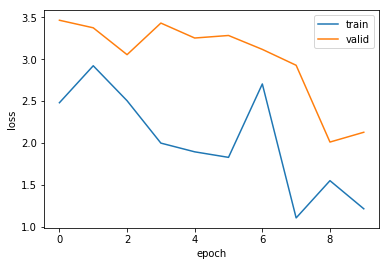

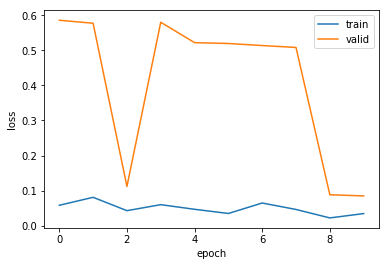

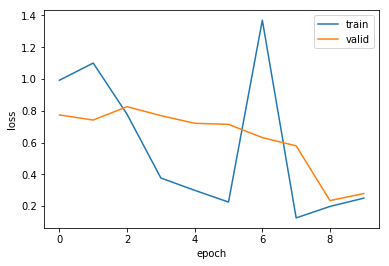

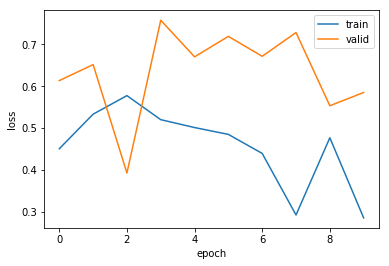

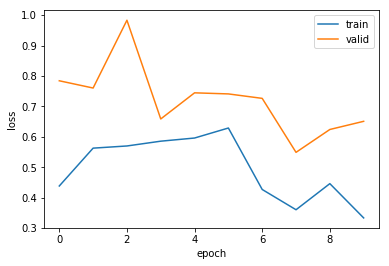

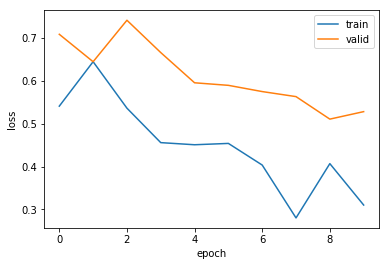

Fine tune all layers

Starting at epoch 11. LR=0.0001

Checkpoint Path: /home/tpol/pytorch-mask-rcnn-samples/logs/fish20181104T2230/mask_rcnn_fish_{:04d}.pth
Epoch 11/20.
	1/4 |██--------| 25.0% Complete - loss: 1.23251 - rpn_class_loss: 0.05291 - rpn_bbox_loss: 0.08723 - mrcnn_class_loss: 0.33260 - mrcnn_bbox_loss: 0.37251 - mrcnn_mask_loss: 0.38725
	2/4 |█████-----| 50.0% Complete - loss: 5.87116 - rpn_class_loss: 0.09756 - rpn_bbox_loss: 3.82384 - mrcnn_class_loss: 0.42581 - mrcnn_bbox_loss: 0.93399 - mrcnn_mask_loss: 0.58996
	3/4 |███████---| 75.0% Complete - loss: 1.57496 - rpn_class_loss: 0.00499 - rpn_bbox_loss: 0.33168 - mrcnn_class_loss: 0.36344 - mrcnn_bbox_loss: 0.54782 - mrcnn_mask_loss: 0.32703
	4/4 |██████████| 100.0% Complete - loss: 0.91505 - rpn_class_loss: 0.00063 - rpn_bbox_loss: 0.11283 - mrcnn_class_loss: 0.24319 - mrcnn_bbox_loss: 0.31127 - mrcnn_mask_loss: 0.24714

	1/1 |██████████| 100.0% Complete - loss: 2.05404 - rpn_class_loss: 0.08585 - rpn_bbox_loss: 0.2727

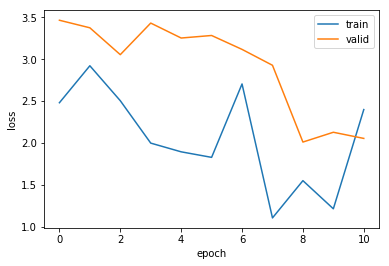

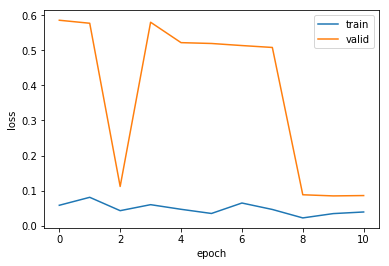

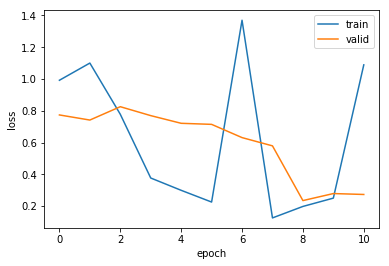

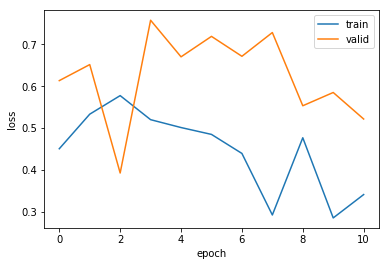

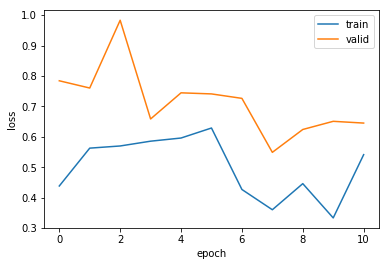

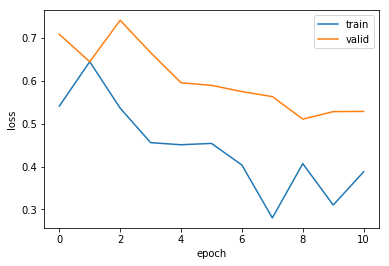

Epoch 12/20.
	1/4 |██--------| 25.0% Complete - loss: 1.19488 - rpn_class_loss: 0.00020 - rpn_bbox_loss: 0.15986 - mrcnn_class_loss: 0.38996 - mrcnn_bbox_loss: 0.39894 - mrcnn_mask_loss: 0.24593
	2/4 |█████-----| 50.0% Complete - loss: 1.27892 - rpn_class_loss: 0.01621 - rpn_bbox_loss: 0.29909 - mrcnn_class_loss: 0.27717 - mrcnn_bbox_loss: 0.40414 - mrcnn_mask_loss: 0.28230
	3/4 |███████---| 75.0% Complete - loss: 1.30247 - rpn_class_loss: 0.03915 - rpn_bbox_loss: 0.11509 - mrcnn_class_loss: 0.37130 - mrcnn_bbox_loss: 0.36651 - mrcnn_mask_loss: 0.41042
	4/4 |██████████| 100.0% Complete - loss: 1.59289 - rpn_class_loss: 0.00374 - rpn_bbox_loss: 0.32715 - mrcnn_class_loss: 0.38473 - mrcnn_bbox_loss: 0.54115 - mrcnn_mask_loss: 0.33612

	1/1 |██████████| 100.0% Complete - loss: 1.94271 - rpn_class_loss: 0.08558 - rpn_bbox_loss: 0.30546 - mrcnn_class_loss: 0.51652 - mrcnn_bbox_loss: 0.52102 - mrcnn_mask_loss: 0.51413



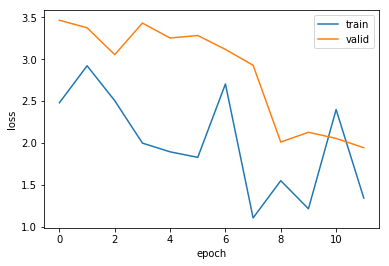

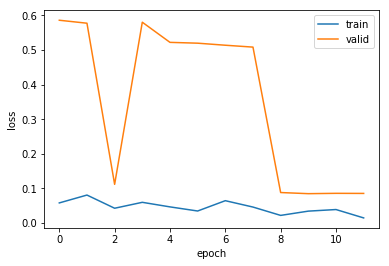

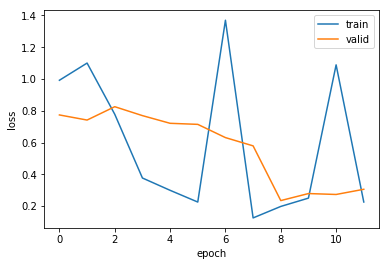

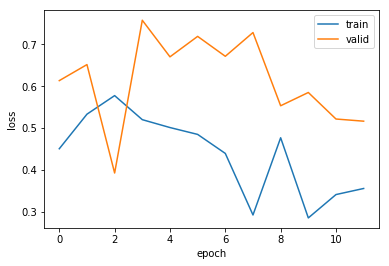

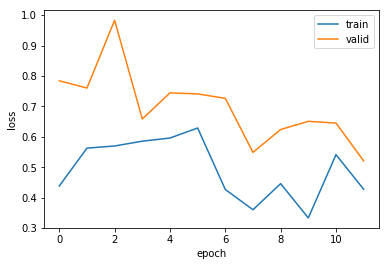

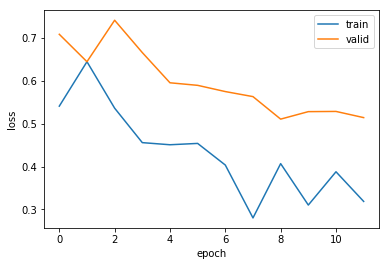

Epoch 13/20.
	1/4 |██--------| 25.0% Complete - loss: 0.47196 - rpn_class_loss: 0.07684 - rpn_bbox_loss: 0.39512 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	2/4 |█████-----| 50.0% Complete - loss: 1.25912 - rpn_class_loss: 0.05258 - rpn_bbox_loss: 0.08823 - mrcnn_class_loss: 0.35472 - mrcnn_bbox_loss: 0.37618 - mrcnn_mask_loss: 0.38741
	3/4 |███████---| 75.0% Complete - loss: 0.99765 - rpn_class_loss: 0.00063 - rpn_bbox_loss: 0.10205 - mrcnn_class_loss: 0.30665 - mrcnn_bbox_loss: 0.34773 - mrcnn_mask_loss: 0.24059
	4/4 |██████████| 100.0% Complete - loss: 1.30689 - rpn_class_loss: 0.01603 - rpn_bbox_loss: 0.25641 - mrcnn_class_loss: 0.35811 - mrcnn_bbox_loss: 0.39624 - mrcnn_mask_loss: 0.28010

	1/1 |██████████| 100.0% Complete - loss: 1.99057 - rpn_class_loss: 0.08518 - rpn_bbox_loss: 0.28776 - mrcnn_class_loss: 0.58468 - mrcnn_bbox_loss: 0.50907 - mrcnn_mask_loss: 0.52387



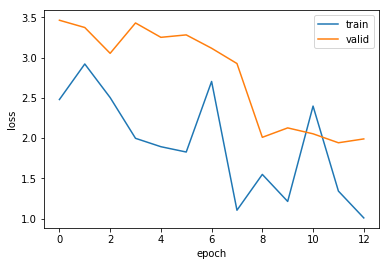

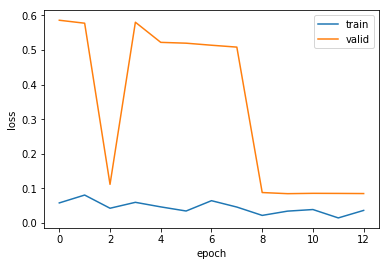

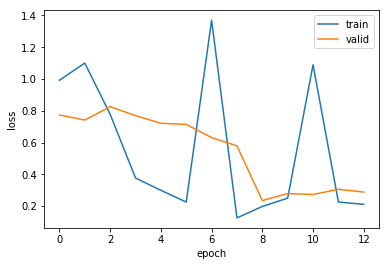

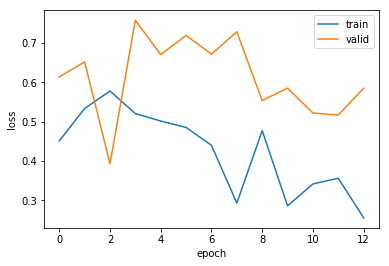

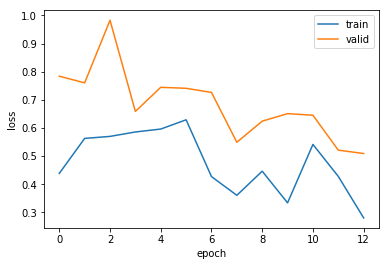

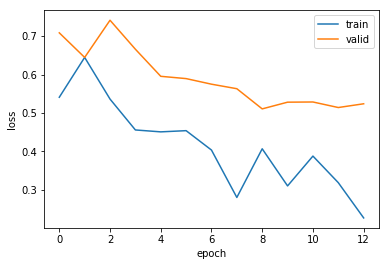

Epoch 14/20.
	1/4 |██--------| 25.0% Complete - loss: 1.61270 - rpn_class_loss: 0.00794 - rpn_bbox_loss: 0.27217 - mrcnn_class_loss: 0.44806 - mrcnn_bbox_loss: 0.41190 - mrcnn_mask_loss: 0.47264
	2/4 |█████-----| 50.0% Complete - loss: 1.09324 - rpn_class_loss: 0.00583 - rpn_bbox_loss: 0.07852 - mrcnn_class_loss: 0.34425 - mrcnn_bbox_loss: 0.41529 - mrcnn_mask_loss: 0.24935
	3/4 |███████---| 75.0% Complete - loss: 2.01563 - rpn_class_loss: 0.06193 - rpn_bbox_loss: 0.46376 - mrcnn_class_loss: 0.39319 - mrcnn_bbox_loss: 0.65028 - mrcnn_mask_loss: 0.44647
	4/4 |██████████| 100.0% Complete - loss: 1.24969 - rpn_class_loss: 0.05205 - rpn_bbox_loss: 0.08879 - mrcnn_class_loss: 0.35570 - mrcnn_bbox_loss: 0.37152 - mrcnn_mask_loss: 0.38162

	1/1 |██████████| 100.0% Complete - loss: 2.98488 - rpn_class_loss: 0.51507 - rpn_bbox_loss: 0.68046 - mrcnn_class_loss: 0.58345 - mrcnn_bbox_loss: 0.64495 - mrcnn_mask_loss: 0.56095



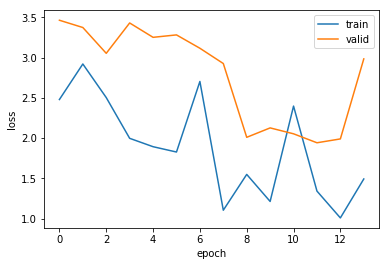

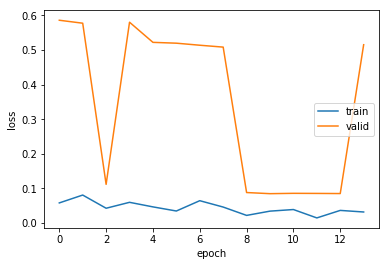

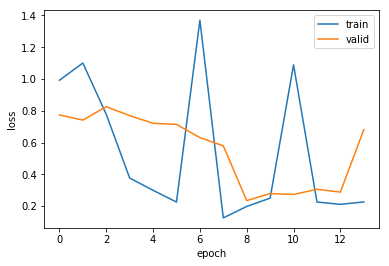

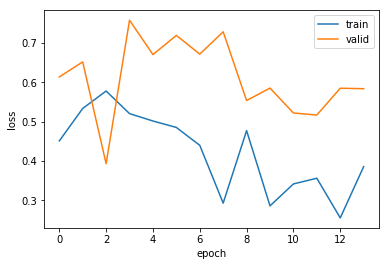

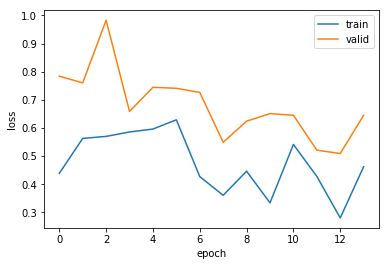

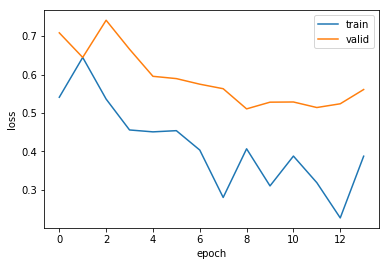

Epoch 15/20.
	1/4 |██--------| 25.0% Complete - loss: 1.70207 - rpn_class_loss: 0.00200 - rpn_bbox_loss: 0.31640 - mrcnn_class_loss: 0.33715 - mrcnn_bbox_loss: 0.65660 - mrcnn_mask_loss: 0.38992
	2/4 |█████-----| 50.0% Complete - loss: 1.78761 - rpn_class_loss: 0.08591 - rpn_bbox_loss: 0.29387 - mrcnn_class_loss: 0.34736 - mrcnn_bbox_loss: 0.55446 - mrcnn_mask_loss: 0.50601
	3/4 |███████---| 75.0% Complete - loss: 0.32299 - rpn_class_loss: 0.08077 - rpn_bbox_loss: 0.24222 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	4/4 |██████████| 100.0% Complete - loss: 1.10478 - rpn_class_loss: 0.00137 - rpn_bbox_loss: 0.01994 - mrcnn_class_loss: 0.32184 - mrcnn_bbox_loss: 0.49227 - mrcnn_mask_loss: 0.26937

	1/1 |██████████| 100.0% Complete - loss: 1.94740 - rpn_class_loss: 0.08391 - rpn_bbox_loss: 0.24378 - mrcnn_class_loss: 0.58301 - mrcnn_bbox_loss: 0.49168 - mrcnn_mask_loss: 0.54502



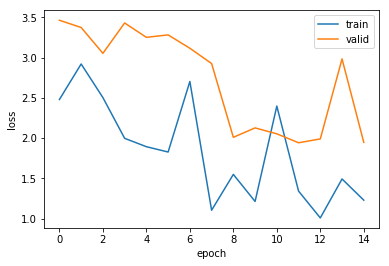

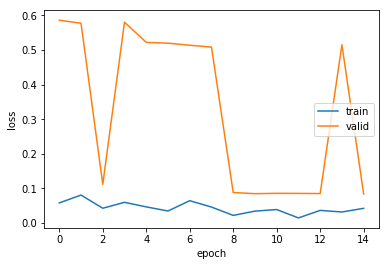

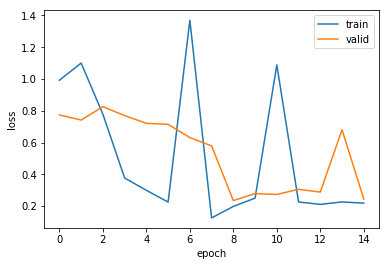

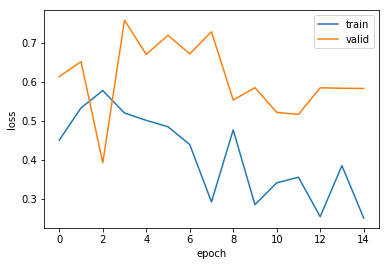

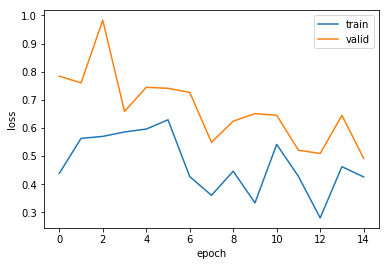

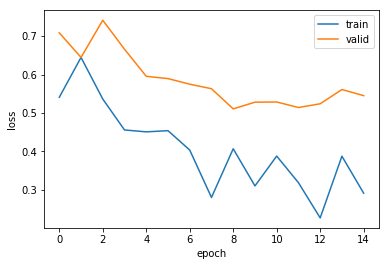

Epoch 16/20.
	1/4 |██--------| 25.0% Complete - loss: 1.22217 - rpn_class_loss: 0.05123 - rpn_bbox_loss: 0.09041 - mrcnn_class_loss: 0.32640 - mrcnn_bbox_loss: 0.37854 - mrcnn_mask_loss: 0.37560
	2/4 |█████-----| 50.0% Complete - loss: 2.09306 - rpn_class_loss: 0.06066 - rpn_bbox_loss: 0.44206 - mrcnn_class_loss: 0.42606 - mrcnn_bbox_loss: 0.72010 - mrcnn_mask_loss: 0.44417
	3/4 |███████---| 75.0% Complete - loss: 1.08301 - rpn_class_loss: 0.00015 - rpn_bbox_loss: 0.15790 - mrcnn_class_loss: 0.29143 - mrcnn_bbox_loss: 0.39057 - mrcnn_mask_loss: 0.24296
	4/4 |██████████| 100.0% Complete - loss: 1.66087 - rpn_class_loss: 0.00153 - rpn_bbox_loss: 0.29042 - mrcnn_class_loss: 0.29521 - mrcnn_bbox_loss: 0.67527 - mrcnn_mask_loss: 0.39844

	1/1 |██████████| 100.0% Complete - loss: 3.00246 - rpn_class_loss: 0.50970 - rpn_bbox_loss: 0.65496 - mrcnn_class_loss: 0.62729 - mrcnn_bbox_loss: 0.64680 - mrcnn_mask_loss: 0.56372



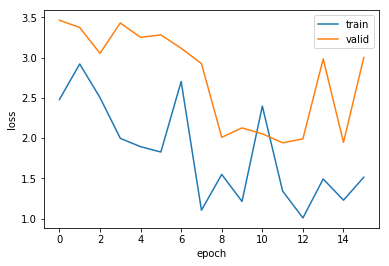

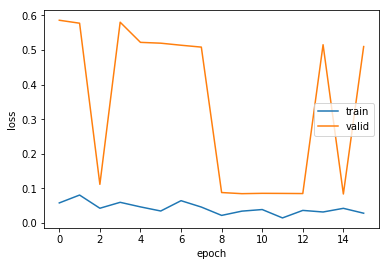

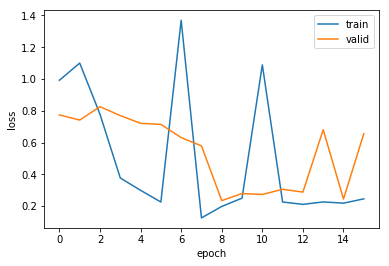

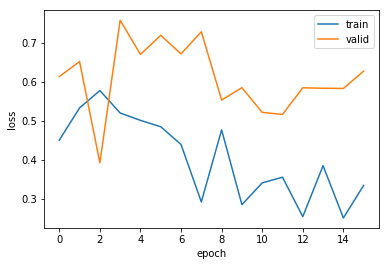

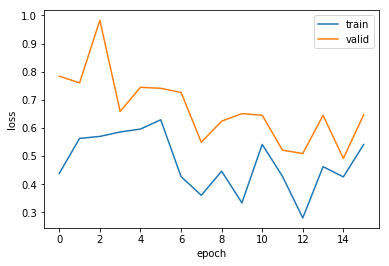

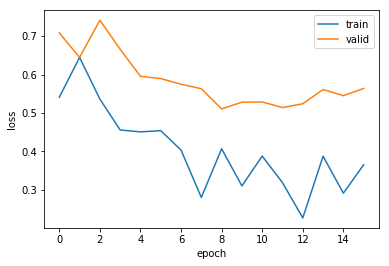

Epoch 17/20.
	1/4 |██--------| 25.0% Complete - loss: 1.09549 - rpn_class_loss: 0.01480 - rpn_bbox_loss: 0.11296 - mrcnn_class_loss: 0.29531 - mrcnn_bbox_loss: 0.39956 - mrcnn_mask_loss: 0.27287
	2/4 |█████-----| 50.0% Complete - loss: 1.50303 - rpn_class_loss: 0.01931 - rpn_bbox_loss: 0.15955 - mrcnn_class_loss: 0.47301 - mrcnn_bbox_loss: 0.46462 - mrcnn_mask_loss: 0.38654
	3/4 |███████---| 75.0% Complete - loss: 1.40344 - rpn_class_loss: 0.03659 - rpn_bbox_loss: 0.13098 - mrcnn_class_loss: 0.34975 - mrcnn_bbox_loss: 0.45305 - mrcnn_mask_loss: 0.43307
	4/4 |██████████| 100.0% Complete - loss: 1.68618 - rpn_class_loss: 0.07599 - rpn_bbox_loss: 0.24306 - mrcnn_class_loss: 0.30941 - mrcnn_bbox_loss: 0.55452 - mrcnn_mask_loss: 0.50320

	1/1 |██████████| 100.0% Complete - loss: 1.81762 - rpn_class_loss: 0.08079 - rpn_bbox_loss: 0.15767 - mrcnn_class_loss: 0.51014 - mrcnn_bbox_loss: 0.50087 - mrcnn_mask_loss: 0.56815



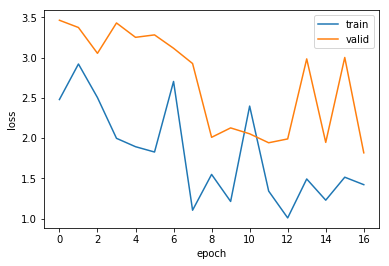

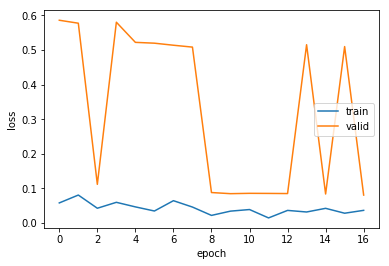

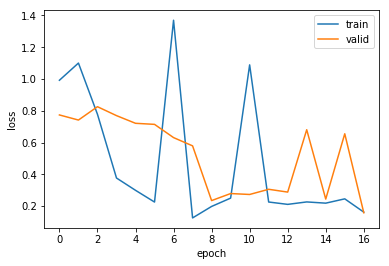

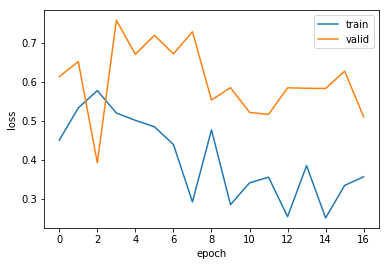

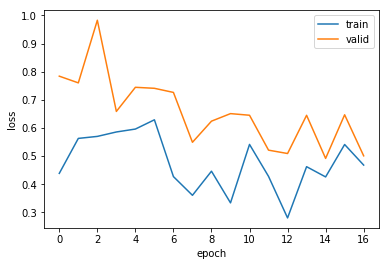

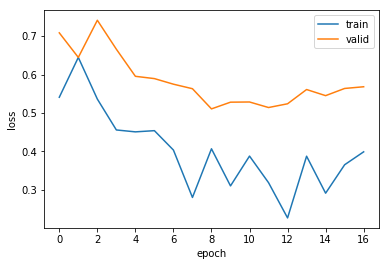

Epoch 18/20.
	1/4 |██--------| 25.0% Complete - loss: 2.04603 - rpn_class_loss: 0.01327 - rpn_bbox_loss: 0.32836 - mrcnn_class_loss: 0.52155 - mrcnn_bbox_loss: 0.60284 - mrcnn_mask_loss: 0.58000
	2/4 |█████-----| 50.0% Complete - loss: 2.03837 - rpn_class_loss: 0.12093 - rpn_bbox_loss: 0.32122 - mrcnn_class_loss: 0.39447 - mrcnn_bbox_loss: 0.59401 - mrcnn_mask_loss: 0.60774
	3/4 |███████---| 75.0% Complete - loss: 5.35671 - rpn_class_loss: 0.09064 - rpn_bbox_loss: 3.41410 - mrcnn_class_loss: 0.50664 - mrcnn_bbox_loss: 0.73775 - mrcnn_mask_loss: 0.60758
	4/4 |██████████| 100.0% Complete - loss: 0.20565 - rpn_class_loss: 0.06450 - rpn_bbox_loss: 0.14114 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000

	1/1 |██████████| 100.0% Complete - loss: 3.00033 - rpn_class_loss: 0.50256 - rpn_bbox_loss: 0.62655 - mrcnn_class_loss: 0.64973 - mrcnn_bbox_loss: 0.64961 - mrcnn_mask_loss: 0.57188



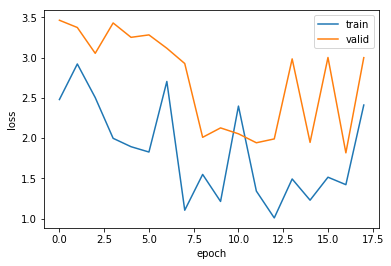

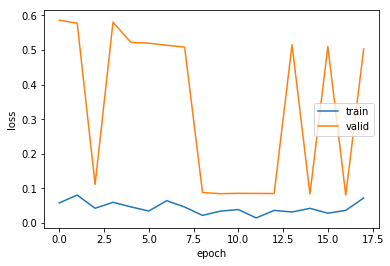

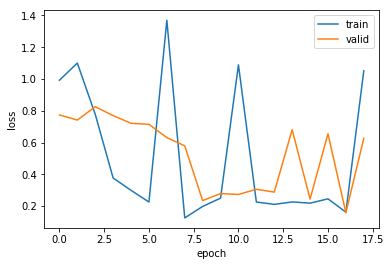

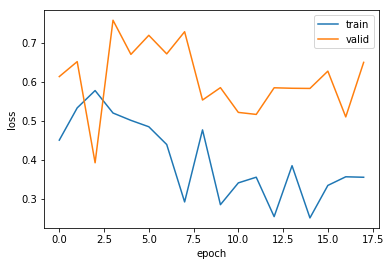

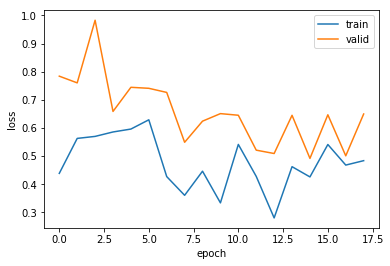

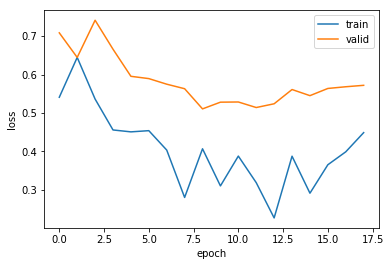

Epoch 19/20.
	1/4 |██--------| 25.0% Complete - loss: 1.18883 - rpn_class_loss: 0.01854 - rpn_bbox_loss: 0.10460 - mrcnn_class_loss: 0.42756 - mrcnn_bbox_loss: 0.28839 - mrcnn_mask_loss: 0.34974
	2/4 |█████-----| 50.0% Complete - loss: 2.04490 - rpn_class_loss: 0.11820 - rpn_bbox_loss: 0.29116 - mrcnn_class_loss: 0.44318 - mrcnn_bbox_loss: 0.59671 - mrcnn_mask_loss: 0.59565
	3/4 |███████---| 75.0% Complete - loss: 1.43300 - rpn_class_loss: 0.03442 - rpn_bbox_loss: 0.15942 - mrcnn_class_loss: 0.36127 - mrcnn_bbox_loss: 0.43823 - mrcnn_mask_loss: 0.43965
	4/4 |██████████| 100.0% Complete - loss: 1.67725 - rpn_class_loss: 0.00544 - rpn_bbox_loss: 0.25861 - mrcnn_class_loss: 0.46753 - mrcnn_bbox_loss: 0.46750 - mrcnn_mask_loss: 0.47817

	1/1 |██████████| 100.0% Complete - loss: 2.97413 - rpn_class_loss: 0.46531 - rpn_bbox_loss: 0.55779 - mrcnn_class_loss: 0.75980 - mrcnn_bbox_loss: 0.61299 - mrcnn_mask_loss: 0.57825



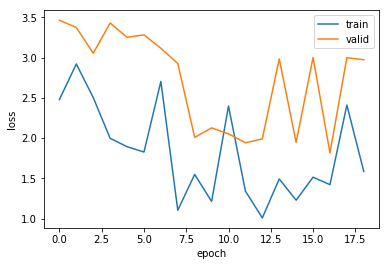

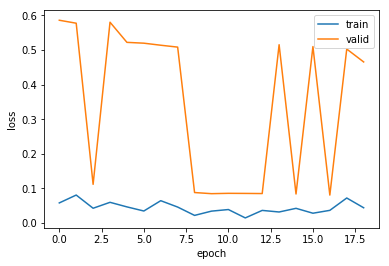

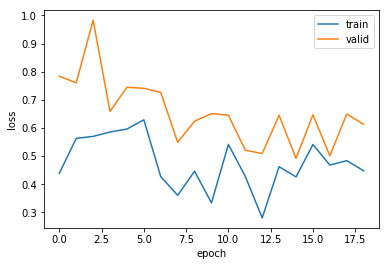

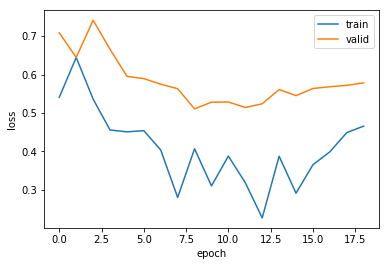

Epoch 20/20.
	1/4 |██--------| 25.0% Complete - loss: 1.18274 - rpn_class_loss: 0.01809 - rpn_bbox_loss: 0.08559 - mrcnn_class_loss: 0.44909 - mrcnn_bbox_loss: 0.27392 - mrcnn_mask_loss: 0.35606
	2/4 |█████-----| 50.0% Complete - loss: 1.30455 - rpn_class_loss: 0.04717 - rpn_bbox_loss: 0.12901 - mrcnn_class_loss: 0.33349 - mrcnn_bbox_loss: 0.42182 - mrcnn_mask_loss: 0.37307
	3/4 |███████---| 75.0% Complete - loss: 1.34499 - rpn_class_loss: 0.00122 - rpn_bbox_loss: 0.20062 - mrcnn_class_loss: 0.23042 - mrcnn_bbox_loss: 0.51135 - mrcnn_mask_loss: 0.40138
	4/4 |██████████| 100.0% Complete - loss: 1.57742 - rpn_class_loss: 0.06889 - rpn_bbox_loss: 0.16831 - mrcnn_class_loss: 0.29818 - mrcnn_bbox_loss: 0.55846 - mrcnn_mask_loss: 0.48357

	1/1 |██████████| 100.0% Complete - loss: 2.98377 - rpn_class_loss: 0.46285 - rpn_bbox_loss: 0.55966 - mrcnn_class_loss: 0.75685 - mrcnn_bbox_loss: 0.62182 - mrcnn_mask_loss: 0.58258



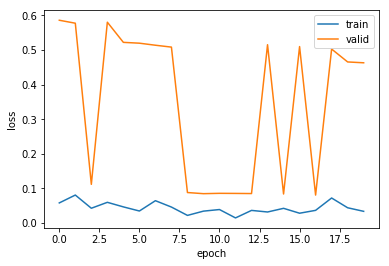

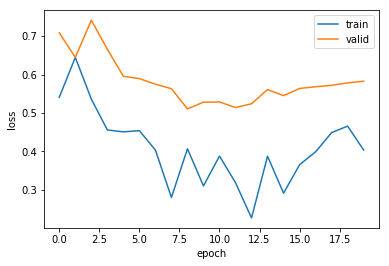

CPU times: user 1min 55s, sys: 1min 30s, total: 3min 25s
Wall time: 2min 48s


In [21]:
%%time

# *** This training schedule is an example. Update to your needs ***

# Training - Stage 1
print("Training network heads")
model.train_model(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=5,
            layers='heads',
            save_plot=False)

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train_model(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='4+',
            save_plot=False)

# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train_model(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20,
            layers='all',
            save_plot=False)


## Detection

In [39]:
! ls logs

fish20181104T2200  fish20181104T2223  fish20181104T2227  fish20181104T2233
fish20181104T2213  fish20181104T2225  fish20181104T2228  fish20181104T2236
fish20181104T2218  fish20181104T2226  fish20181104T2230  fish20181104T2237


In [45]:
# Example of loading a previously trained model checkpoint
model = modellib.MaskRCNN(model_dir=MODEL_DIR, config=config)
model.load_state_dict(torch.load(os.path.join('logs', 'fish20181104T2200', 'mask_rcnn_fish_0020.pth')))
if torch.cuda.is_available():
    model = model.cuda()

In [46]:
# ! ls fish_pics/test/


In [47]:
pic_file = glob.glob(os.path.join('fish_pics' , 'test', '*.jpg'))[3]
# pic_file = os.path.join('fish_pics', '35301600622_8bc287ac45_o.jpg')
# pic_file = os.path.join('fish_pics', 'test', 'frame_31050.jpg')
# pic_file = glob.glob('images/*.*')[0]


# im = array(Image.open(pic_file).convert('L'))
# original_image,T = denoise(im,im)
# print(original_image.shape)
# original_image = original_image.astype(int)
# original_image = skimage.color.gray2rgb(original_image)
# print(original_image.shape)

# img = histogram_strech(Image.open(pic_file))
# original_image = np.asarray(img)

original_image = plt.imread(pic_file)
plt.imshow(original_image)


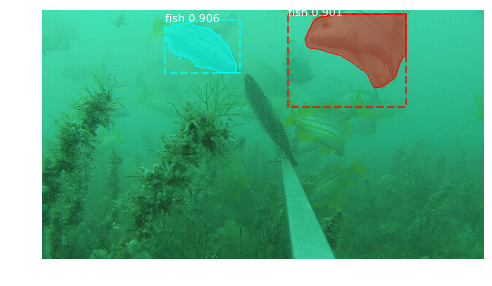

In [48]:
results = model.detect([original_image])

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], ax=get_ax())

In [ ]:
pic_file = glob.glob('images/*.*')[0]

original_image = plt.imread(pic_file)
plt.imshow(original_image)

In [ ]:
results = model.detect([original_image])

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
class InferenceConfig(FishConfig):
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".pth file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

### Calculate Mean Average Precision (mAP)

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 5)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image])
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))